# Project 3: Web APIs and NLP <br>

#### Brandie Hatch

### Modeling

## Imports, Data Reading, and Model Prep

In [48]:
# python library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeRegressor, plot_tree, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, RidgeCV, Ridge, Lasso, ElasticNet, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_transformer, ColumnTransformer, TransformedTargetRegressor
from sklearn.svm import LinearSVC, SVC 
from sklearn.feature_extraction.text import CountVectorizer


%matplotlib inline
pd.options.display.max_columns =999

import requests
import time
import re
import nltk

In [49]:
# Read in Data

df = pd.read_csv('../data/prepped.csv', index_col=False)
print(df.shape)
df.head()

(9436, 11)


,num_comments,score,selftext,subreddit,title,text,title_length,title_word_count,selftext_length,selftext_word_count,subreddit_num
0,2,1,The wife and I adopted a 1 to 3 year old beagl...,Dogtraining,Rescue dog will not come inside from fenced in...,Rescue dog will not come inside from fenced in...,51,10,986,203,1
1,1,1,I have an 8 month old Rottweiler puppy who is ...,Dogtraining,“Drop it” fails,“Drop it ” fails I have an 8 month old Rottwei...,15,3,1056,207,1
2,1,1,Long story short we used to have two dogs. A d...,Dogtraining,My dog will ONLY submissive pee.,My dog will ONLY submissive pee . Long story s...,32,6,732,147,1
3,1,1,I’ve recently adopted a golden retriever! He’s...,Dogtraining,Separation anxiety in dog used to living in a ...,Separation anxiety in dog used to living in a ...,51,10,573,112,1
4,1,1,**TLDR:** Do you leave your dog unsupervised ...,Dogtraining,"So, is my backyard making my dog more reactive?","So , is my backyard making my dog more reactiv...",47,9,1866,330,1


In [50]:
# imported data split between two subreddits
df['subreddit'].value_counts(normalize=True)

Dogtraining     0.500424
service_dogs    0.499576
Name: subreddit, dtype: float64

In [51]:
# Create X and y using StandardScaler to scale values

X = df.drop(columns=['subreddit', 'subreddit_num', 'title', 'selftext'])
y = df['subreddit_num']

In [52]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [53]:
# calculate the baseline accuracy (% of the majority class, dogtraining)
# benchmark to beat is .502732
y.value_counts(normalize=True)

1    0.500424
0    0.499576
Name: subreddit_num, dtype: float64

## Modeling

### Random Forest Classifier

In [54]:
# column transformer, countvectorizer needs to only go to the text columns
col_trans = ColumnTransformer([
    ('cvex', CountVectorizer(lowercase=True, stop_words={'english'}), 'text'),
    ('ss', StandardScaler(), ['score', 'num_comments', 'title_length', 'title_word_count', 'selftext_length', 'selftext_word_count'])],
    remainder='passthrough',
    sparse_threshold=0
)

In [55]:
col_trans.fit(X_train)

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('cvex',
                                 CountVectorizer(stop_words={'english'}),
                                 'text'),
                                ('ss', StandardScaler(),
                                 ['score', 'num_comments', 'title_length',
                                  'title_word_count', 'selftext_length',
                                  'selftext_word_count'])])

In [56]:
col_trans.transform(X_train)

array([[ 0.        ,  0.        ,  0.        , ...,  0.00784865,
         4.03839705,  4.09657099],
       [ 0.        ,  0.        ,  0.        , ..., -1.03943033,
        -0.64380322, -0.69326259],
       [ 0.        ,  0.        ,  0.        , ..., -1.21397682,
        -0.42467672, -0.47383304],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.18239514,
         0.15334345,  0.12803087],
       [ 0.        ,  0.        ,  0.        , ..., -0.51579084,
        -0.24345318, -0.22932583],
       [ 0.        ,  0.        ,  0.        , ..., -0.51579084,
         1.15421854,  1.16875387]])

In [57]:
# pipeline StandardScaler + instantiate RandomForestClassifier
pipe = Pipeline([
    ('col_trans', col_trans),
    ('rf', RandomForestClassifier())
])

In [58]:
params = {
    'rf__n_estimators': [1, 100, 200],
    'rf__max_depth': [None, 1, 2, 3, 4, 5]
}
gs = GridSearchCV(pipe, param_grid=params, cv=5)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

0.952763058289175


{'rf__max_depth': None, 'rf__n_estimators': 200}

In [59]:
print(y_train.mean(), y_test.mean())

0.5003785011355034 0.5005298481102084


In [60]:
pd.DataFrame(gs.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rf__max_depth,param_rf__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
2,44.720746,0.760179,0.516693,0.038771,None,200,"{'rf__max_depth': None, 'rf__n_estimators': 200}",0.962907,0.951552,0.944739,0.958365,0.946253,0.952763,0.006964,1
1,23.171087,0.186736,0.419532,0.007114,None,100,"{'rf__max_depth': None, 'rf__n_estimators': 100}",0.962150,0.948524,0.945496,0.960636,0.941711,0.951703,0.008215,2
17,13.375733,0.122760,0.387531,0.008171,5,200,"{'rf__max_depth': 5, 'rf__n_estimators': 200}",0.906889,0.906132,0.897048,0.919758,0.876609,0.901287,0.014304,3
16,8.130831,0.466495,0.436134,0.047179,5,100,"{'rf__max_depth': 5, 'rf__n_estimators': 100}",0.890235,0.887207,0.887207,0.922786,0.908403,0.899167,0.014206,4
14,11.715391,0.115836,0.435764,0.030490,4,200,"{'rf__max_depth': 4, 'rf__n_estimators': 200}",0.912188,0.880394,0.897805,0.897048,0.902347,0.897956,0.010306,5
13,6.711440,0.280110,0.475193,0.094500,4,100,"{'rf__max_depth': 4, 'rf__n_estimators': 100}",0.912945,0.909917,0.875852,0.889478,0.875852,0.892808,0.016027,6
5,4.290004,0.083759,0.458434,0.067318,1,200,"{'rf__max_depth': 1, 'rf__n_estimators': 200}",0.934141,0.881151,0.900833,0.853899,0.869796,0.887964,0.027694,7
7,4.100731,0.073703,0.379422,0.018517,2,100,"{'rf__max_depth': 2, 'rf__n_estimators': 100}",0.891749,0.858441,0.877366,0.934141,0.873581,0.887055,0.025820,8
8,6.752865,0.124248,0.405672,0.017005,2,200,"{'rf__max_depth': 2, 'rf__n_estimators': 200}",0.885693,0.884936,0.878880,0.891749,0.890235,0.886298,0.004527,9
11,9.140648,0.204579,0.429907,0.054683,3,200,"{'rf__max_depth': 3, 'rf__n_estimators': 200}",0.900076,0.875852,0.868282,0.890235,0.884936,0.883876,0.011059,10


In [61]:
gs.score(X_train, y_train)

1.0

In [62]:
gs.score(X_test, y_test)

0.9547862945955493

### Decision Tree Classifier


In [63]:
# column transformer, countvectorizer needs to only go to the text columns
col_trans_tree = ColumnTransformer([
    ('cvex', CountVectorizer(lowercase=True, stop_words={'english'}), 'text'),
    ('ss', StandardScaler(), ['score', 'num_comments', 'title_length', 'title_word_count', 'selftext_length', 'selftext_word_count'])],
    remainder='passthrough',
    sparse_threshold=0
)

In [64]:
col_trans_tree.fit(X_train)

ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                  transformers=[('cvex',
                                 CountVectorizer(stop_words={'english'}),
                                 'text'),
                                ('ss', StandardScaler(),
                                 ['score', 'num_comments', 'title_length',
                                  'title_word_count', 'selftext_length',
                                  'selftext_word_count'])])

In [65]:
col_trans_tree.transform(X_train)

array([[ 0.        ,  0.        ,  0.        , ...,  0.00784865,
         4.03839705,  4.09657099],
       [ 0.        ,  0.        ,  0.        , ..., -1.03943033,
        -0.64380322, -0.69326259],
       [ 0.        ,  0.        ,  0.        , ..., -1.21397682,
        -0.42467672, -0.47383304],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.18239514,
         0.15334345,  0.12803087],
       [ 0.        ,  0.        ,  0.        , ..., -0.51579084,
        -0.24345318, -0.22932583],
       [ 0.        ,  0.        ,  0.        , ..., -0.51579084,
         1.15421854,  1.16875387]])

In [66]:
# pipeline StandardScaler + instantiate decision tree classifier
pipe_tree = Pipeline([
    ('col_trans_tree', col_trans_tree),
    ('tree', DecisionTreeClassifier())
])

In [67]:
params_tree = {
    'tree__random_state': [1, 2],
    'tree__max_depth': [None, 1, 2, 3]
}
tree_gs = GridSearchCV(pipe_tree, param_grid=params_tree, cv=5)
tree_gs.fit(X_train, y_train)
print(tree_gs.best_score_)
tree_gs.best_params_

0.953217259651779


{'tree__max_depth': None, 'tree__random_state': 1}

In [68]:
tree_gs.score(X_train, y_train), tree_gs.score(X_test, y_test)

(1.0, 0.949134581419993)

In [69]:
pd.Series(tree_gs.predict(X_test)).value_counts()

1    1423
0    1408
dtype: int64

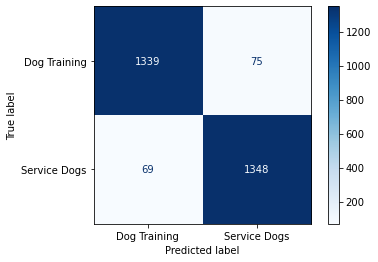

In [70]:
ConfusionMatrixDisplay.from_estimator(
    tree_gs, 
    X_test, 
    y_test, 
    display_labels=['Dog Training', 'Service Dogs'], 
    cmap='Blues'
);

In [71]:
accuracy_score(y_test, tree_gs.predict(X_test))

0.949134581419993

In [72]:
y_test.sum()/y_test.count()

0.5005298481102084

In [73]:
roc_auc_score(y_test, gs.predict(X_test))

0.9547787574402162

In [74]:
precision_score(y_test, gs.predict(X_test))

0.9485038274182325

In [75]:
recall_score(y_test, gs.predict(X_test))

0.9618913196894848

In [76]:
# specificity
recall_score(y_test, gs.predict(X_test), pos_label=0)

0.9476661951909476

In [77]:
f1_score(y_test, gs.predict(X_test))

0.9551506657323054

In [78]:
y_test.value_counts(normalize=True)

1    0.50053
0    0.49947
Name: subreddit_num, dtype: float64

### Support Vector Machines (SVM): Linear SVC & C-Support Vector Classification

In [83]:
# define linspace variable
pgrid = ['C', np.linspace(0.0001, 1, 20)]

In [84]:
# pipeline StandardScaler + instantiate RandomForestClassifier
pipe_svm = Pipeline([
    ('col_trans', col_trans),
    ('ln_svc', LinearSVC())
])

In [86]:
# instantiate and fit gridsearch

params_svm = {
    'ln_svc__max_iter': [5000, 10000]
}
gs_svm = GridSearchCV(pipe_svm, param_grid=params_svm, cv=5)
gs_svm.fit(X_train, y_train)
print(gs_svm.best_score_)
gs_svm.best_params_


#gs_svm = GridSearchCV(LinearSVC(max_iter=5000), pgrid)

#gs_svm.fit(X, y)

0.9609386828160484


{'ln_svc__max_iter': 5000}

In [87]:
print(gs_svm.best_score_)
print(gs_svm.best_params_)

0.9609386828160484
{'ln_svc__max_iter': 5000}


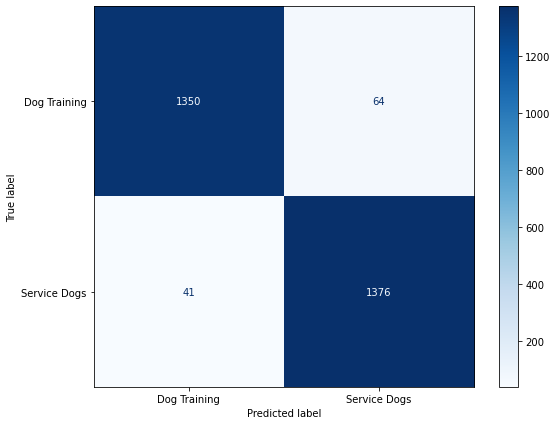

In [92]:
fig, ax = plt.subplots(figsize=(9, 7))
ConfusionMatrixDisplay.from_estimator(gs_svm,
                                      X_test,
                                      y_test,
                                      display_labels=['Dog Training', 'Service Dogs'], 
                                      cmap='Blues', 
                                      ax=ax);

In [89]:
(3619+1)/(3619+1+1367+3)

0.7254509018036072

In [90]:
y_test

6838    0
8813    0
4242    1
7517    0
5906    0
       ..
5876    0
4073    1
3868    1
1134    1
1985    1
Name: subreddit_num, Length: 2831, dtype: int64

In [105]:
# pipeline StandardScaler + instantiate decision tree classifier
pipe_svc = Pipeline([
    ('col_trans_tree', col_trans_tree),
    ('svc', SVC())
])

In [107]:

pgrid_svc = {
    'svc__C': [None, 1, 2],
    'svc__kernel': ['poly'],
    'svc__degree': [2],
    'svc__gamma': ['scale'] 
}
gs_svc = GridSearchCV(pipe_svc, param_grid=pgrid_svc, cv=5)
gs_svc.fit(X_train, y_train)
print(gs_svc.best_score_)
gs_svc.best_params_

c:\Users\hatch\anaconda3\envs\dsi-222\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 15.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\hatch\anaconda3\envs\dsi-222\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\hatch\anaconda3\envs\dsi-222\lib\site-packages\sklearn\pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "c:\Users\hatch\anaconda3\envs\dsi-222\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, samp

0.8996214988644965


{'svc__C': 2, 'svc__degree': 2, 'svc__gamma': 'scale', 'svc__kernel': 'poly'}

In [108]:
# Create DataFrame with column for predicted values.
results = pd.DataFrame(gs_svc.predict(X_test), columns=['predicted'])
# Create column for observed values.
results['actual'] = y_test
results.head()

,predicted,actual
0,0,NaN
1,0,NaN
2,1,NaN
3,0,NaN
4,0,NaN


## Model Evaluation & Comparison

ValueError: could not convert string to float: "Should I take my assistance dog overseas ? AUS -USA This is the main part of my post , after the break I have a couple of additional questions that I would also really appreciate advice on but I know this post is already super long so no worries if you can 't read the second part as well haha . Hi all ! I am from Australia and I have a psychiatric assistance dog . Currently he is still in training but he will be finished by the time we actually go . My family is planning on taking a trip to the US in two or three years , and I am really unsure as to whether I should bring him . Having him with me would be an amazing help as I will be quite scared and overwhelmed in a foreign country especially as my parents aren 't really great with coping with me when I 'm like that . The only thing that is giving me doubts is that one of the main reasons we are going to the US is to go to Disney . To be honest , I have absolutely no idea how he would do . And I don 't even really know how we could practice for it . We do have Movie World in Australia which I think is pretty much the only theme park here which even begins to compare to Disney . But it would be so , so much money to go there 10 + times in order to get him trained up enough especially considering I don 't even like Movie World LMAO . Obviously all asisstance dogs need to be bomb -proof, but I know he will need to be like nuclear warfare -proof to go to Disney . So I think maybe in a year or two time I will just take him once or twice to Movie World and if he nails it I will probably take him to the US but if he doesn 't cope I will have to leave him , as I know Disney will be 100x more busy , loud , and intense . Does this sound like an ok plan ? Arghhh I don 't know what to do . Can you think of any places we could train for it that don 't cost $100 per visit ? If I decide he 's not up to going to Disney , do you think it would be possible to still bring him to the US and just board him or something for the day that we go to Disney ? Thank you all so so much for reading . Below are my additional questions if you have time . Also , please let me know if there 's anything I haven 't considered that I need to . ________________________ Additional advice ? Will I be able to enjoy my experience at Disney with him there ? I 'm not really into fast or scary rides so I don 't think that would be an issue , and I know there are some calmer rides that are safe for dogs . I think I could probably enjoy my experience there without going on any rides at all though . It looks like there is a lot to do and a lot to look at even without doing rides - is that correct ? I don 't think he would ruin my experience . I think the distress and fear of being there without him would be more likely to ruin my experience though obviously I will just deal with it if he 's not going to cope . Also , how would it work legally ? The laws in Australia (in my state at least ) are pretty similar to the US from what I understand . My assistance dog complies with both Australian and American assistance /service dog laws . So would we face any issues bringing him as foreigners or should it be fine ? Am I correct to assume that any hotel in the US would have to house us ? And should I tell them about him first or wait til after our booking has been confirmed ? Is it better to use my org vest labelled assistance dog or should I get one for America labelled service dog to avoid confusion ? Also , I am concerned that flying may be an issue . I know in the US even ESAs can go on planes but from my understanding it 's hard to even get proper assistance dogs on planes in Australia . Even though owner training is completely legal here , AFAIK most if not all airlines only accept organisation dogs . We are working with an owner training org (not gonna name names publicly because I don 't know if that 's allowed , but it 's the only owner training psychiatric assistance dog org here ) but not every airline accepts dogs from my org . Legally assistance dogs have access to all public places and housing and public transport such as buses and trains , but I don 't believe they legally must be allowed to access planes . My understanding on this may be a little flawed and I probably need to do more research on this by myself but if you 're an Aussie with experience flying with your assistance dog I would really really appreciate any advice you could give . Thank you so much again if you read all of this !!!"

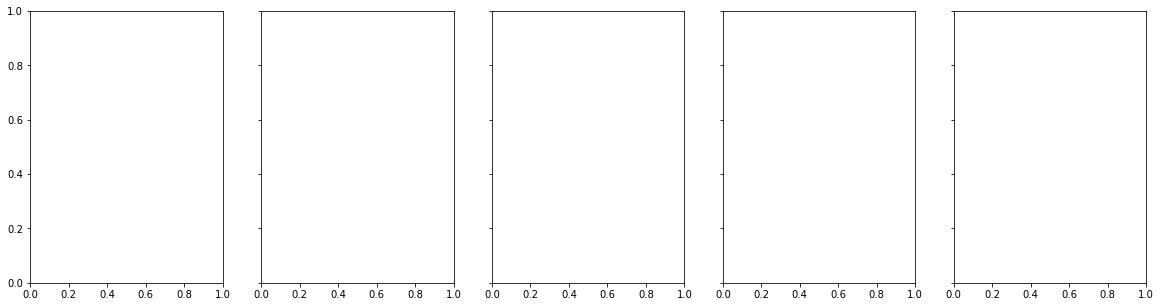

In [118]:
classifiers = {
    "Random Forest Classifier": RandomForestClassifier(),
    "Decision Tree Classifier": DecisionTreeClassifier(),
    "Linear SVC": LinearSVC(),
    "Support Vector Classifier": SVC(),
    "LogisiticRegression": LogisticRegression(),
}

f, axes = plt.subplots(1, 5, figsize=(20, 5), sharey='row')

for i, (key, classifier) in enumerate(classifiers.items()):
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cf_matrix,
                                  display_labels=['Dog Training', 'Service Dogs'])
    disp.plot(ax=axes[i], xticks_rotation=45)
    disp.ax_.set_title(key)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

f.text(0.4, 0.1, 'Predicted label', ha='left')
plt.subplots_adjust(wspace=0.40, hspace=0.1)


f.colorbar(disp.im_, ax=axes)
plt.show()

In [110]:
accuracy_score(y_test, tree_gs.predict(X_test))

0.949134581419993

In [111]:
y_test.sum()/y_test.count()

0.5005298481102084

In [112]:
roc_auc_score(y_test, gs.predict(X_test))

0.9547787574402162

In [113]:
precision_score(y_test, gs.predict(X_test))

0.9485038274182325

In [114]:
recall_score(y_test, gs.predict(X_test))

0.9618913196894848

In [115]:
# specificity
recall_score(y_test, gs.predict(X_test), pos_label=0)

0.9476661951909476

In [116]:
f1_score(y_test, gs.predict(X_test))

0.9551506657323054

In [117]:
y_test.value_counts(normalize=True)

1    0.50053
0    0.49947
Name: subreddit_num, dtype: float64

## Answer Problem, Conclusions, and Recommendations

## Sources